# Project 1: Rocket Landing


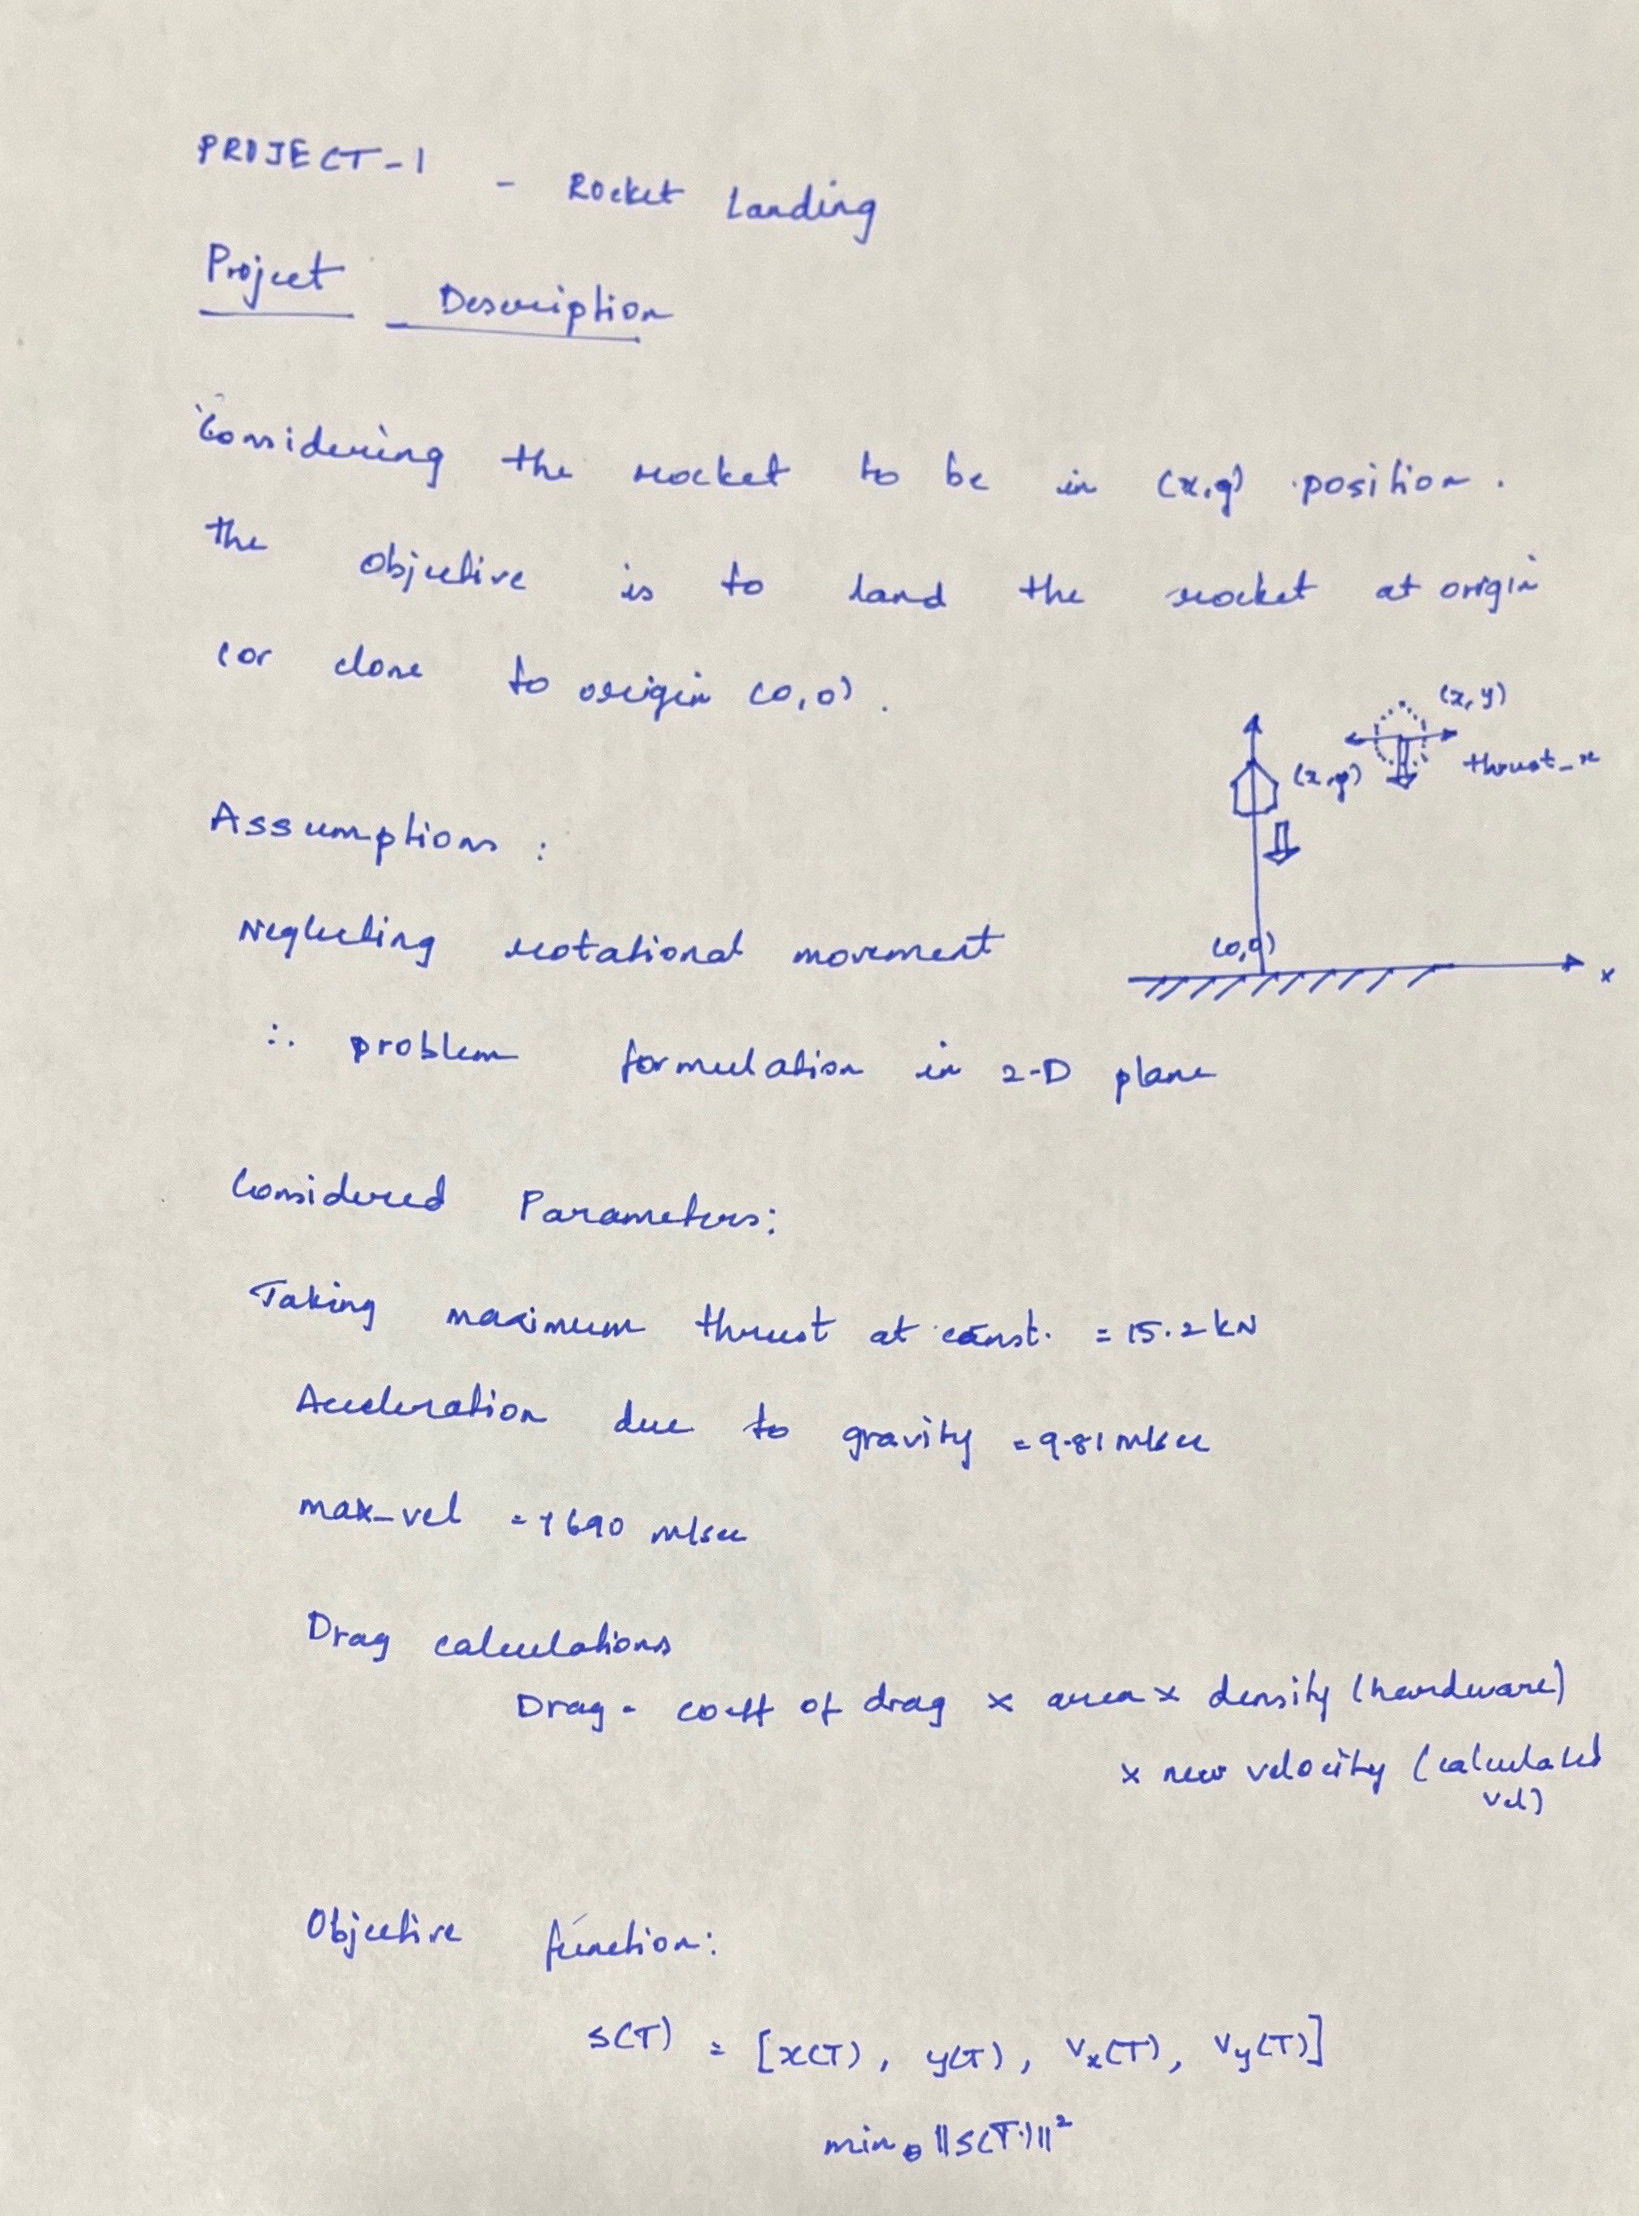

In [3]:
# Header
import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt
logger = logging.getLogger(__name__)

In [4]:
# environment parameters

FRAME_TIME = 0.1  # time interval (ft)
GRAVITY_ACCEL = 9.81  # gravity constant (g)
BOOST_ACCEL = 18  # thrust constant

# # the following parameters are not being used in the sample code
# PLATFORM_WIDTH = 0.25  # landing platform width
# PLATFORM_HEIGHT = 0.06  # landing platform height
# ROTATION_ACCEL = 20  # rotation constant

## the below parameters used in this problem 
max_thrust= 15.2 # assuming maximum thrust as a constant value of 15.2 Kn
payload_weight= 1720  # Weigth of rocket without fuel 
#reference https://www.isro.gov.in/launchers/pslv 
#while formularioning decclration centre of mass is considered (not lift of mass)
lift_off_mass=320000  # the total mass of rocket 
max_vel = 7690 #m/s
ACCEL_along_x = 0.15
ROTATION_ACCEL = 0.75

In [5]:
# define system dynamics     ## if variables are added or updated changes to be made here 
# Notes: 
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        
        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[1] = x[1] + gravity * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[1]) that is part of the computational graph to be differentiated.
        # Therefore, I define a tensor dx = [0., gravity * delta_time], and do x = x + dx. This is allowed... 
        delta_state_gravity = t.tensor([0., GRAVITY_ACCEL * FRAME_TIME])
        

        # Thrust
        # Note: Same reason as above. Need a 2-by-1 tensor.
        delta_state = BOOST_ACCEL * FRAME_TIME * t.tensor([0., -1.]) * action
        new_vel = delta_state

        #coeff_drag = 0.25 ## Drag co-efficint of cyclinder with a cone on top 
        Area = 6.154 ## = 3.14 * (1.4 ^2) m^2
        Hardware_Density = 7850 ## kg/m^3 ; Considering the structure as Mild steel 
        ## Dragforce: D = Cd * A * .5 * r * V^2
        Drag = 0.5* 0.25 * Area * Hardware_Density * delta_state**2
        Decel = 0.006308 * new_vel* new_vel
        NET_ACCEL = BOOST_ACCEL - Decel
        
        ## Velocity during decent 
        delta_state = NET_ACCEL * FRAME_TIME * t.tensor([0., -1.]) * action
        state = state + delta_state + delta_state_gravity
        

        #delta_state_gravity = t.tensor([0., -GRAVITY_ACCEL * FRAME_TIME, 0, 0]) 
        #delta_state_1 = Total_decc * FRAME_TIME * t.tensor([0., 1., 0., 0.]) * action[1] 
        #delta_state_rotation = t.tensor([0., 0, 0, ROTATION_ACCEL* FRAME_TIME]) 
        #delta_state_angular = ACCEL_along_x * FRAME_TIME * t.tensor([0., 0, 0, -1.]) * action[0] 
        #state = state + delta_state_1 + delta_state_gravity + delta_state_rotation + delta_state_angular 

        
       ## m * DRAG_DECEL (deceleration due to drag) = Drag 
       ## DRAG_DECEL = 0.00658 * delta_state**2  
        #vertical landing acc
        #vertical_acc = (max_thrust - payload_weight)/lift_off_mass max_vel = vertical_acc*FRAME_TIME

        
        # Update state
        # Note: Same as above. Use operators on matrices/tensors as much as possible. Do not use element-wise operators as they are considered inplace.
        step_mat = t.tensor([[1., FRAME_TIME],
                            [0., 1.]])
        state = t.matmul(step_mat, state)

        return state

In [6]:
# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Linear(dim_hidden, dim_output),
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

In [7]:
# the simulator that rolls out x(1), x(2), ..., x(T)     ## intial conditions and state 
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state(): 
        state = [20., 0.]  # TODO: need batch of initial states  ## Position of the expected output 
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        return state[0]**2 + state[1]**2

In [8]:
# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):       ### try tp print the loss function 
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        y = data[:, 1]
        plt.plot(x, y)
        plt.title('Displacement vs velocity')
        plt.xlabel('Displacement')
        plt.ylabel('Velocity')
        plt.show()
        

[1] loss: 10133.869


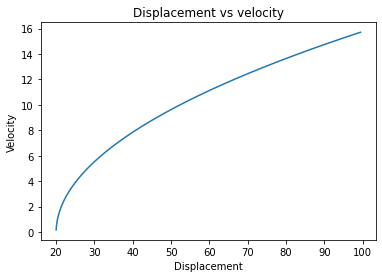

[2] loss: 3932.271


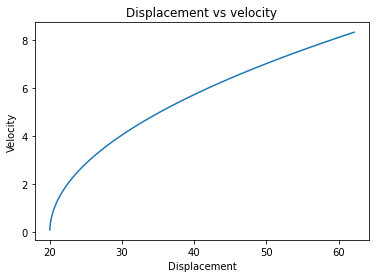

[3] loss: 1765.176


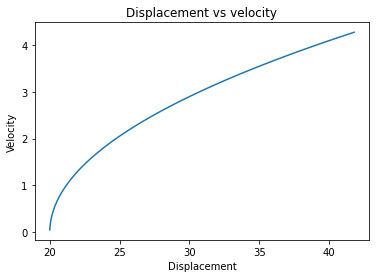

[4] loss: 925.479


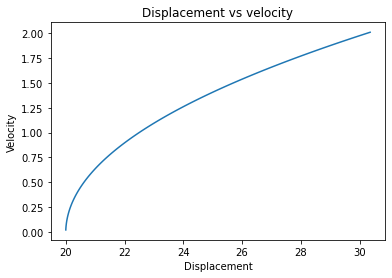

[5] loss: 538.836


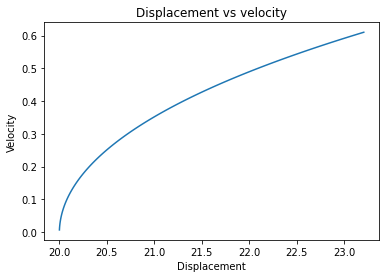

[6] loss: 338.339


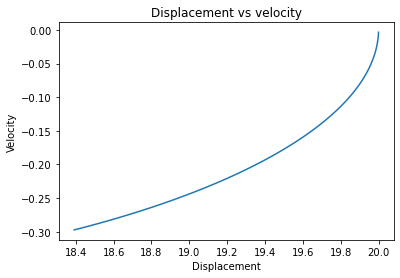

[7] loss: 224.595


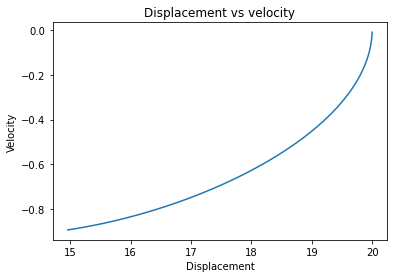

[8] loss: 154.889


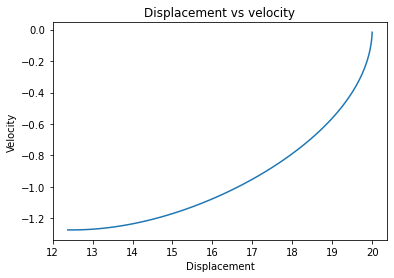

[9] loss: 107.232


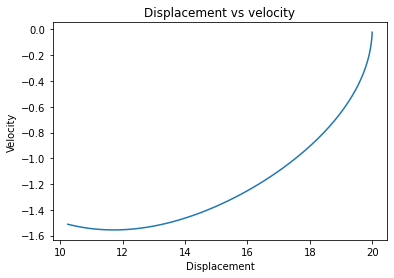

[10] loss: 71.104


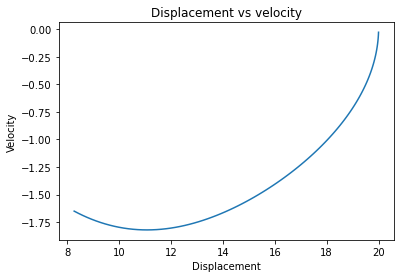

[11] loss: 44.785


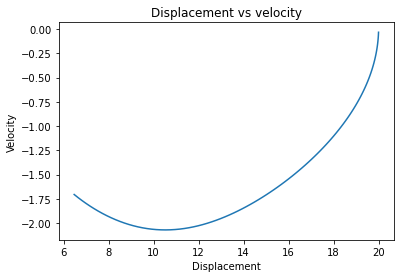

[12] loss: 27.782


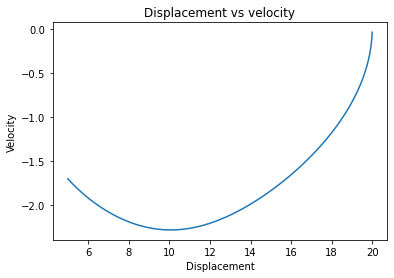

[13] loss: 17.440


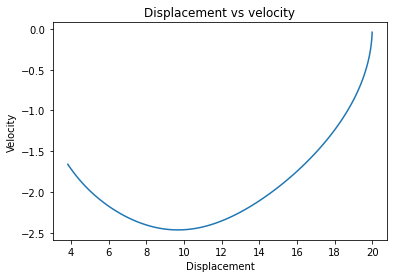

[14] loss: 11.063


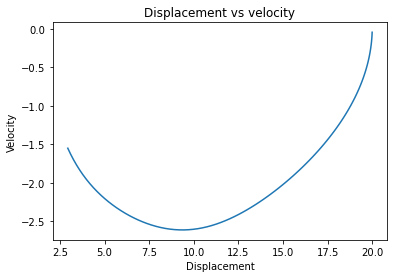

[15] loss: 7.057


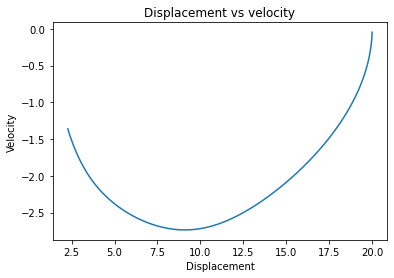

[16] loss: 4.644


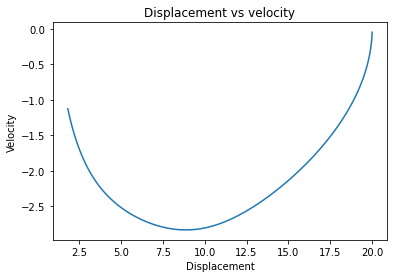

[17] loss: 3.201


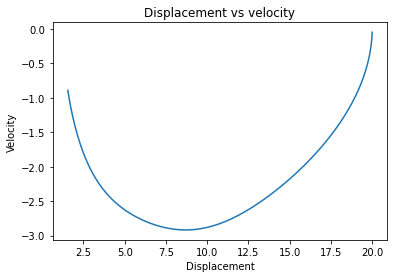

[18] loss: 2.335


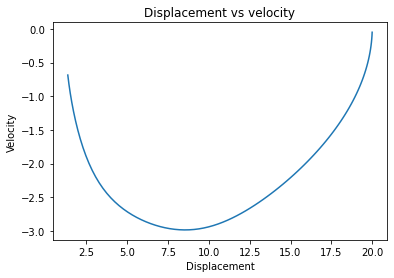

[19] loss: 1.809


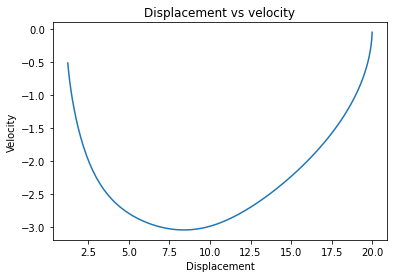

[20] loss: 1.471


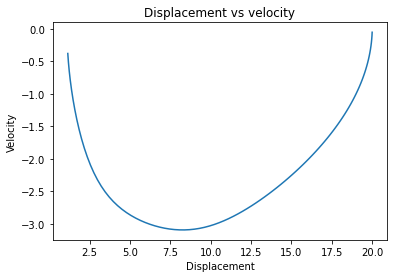

[21] loss: 1.251


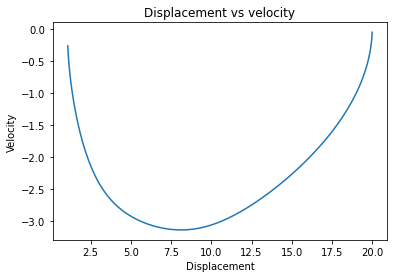

[22] loss: 1.106


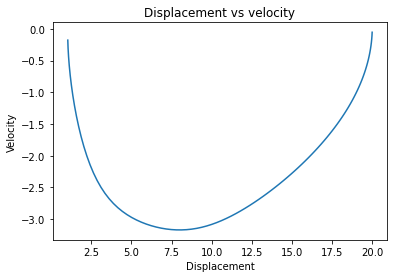

[23] loss: 0.980


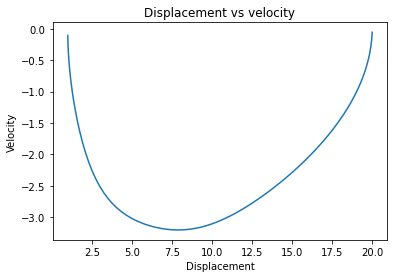

[24] loss: 0.744


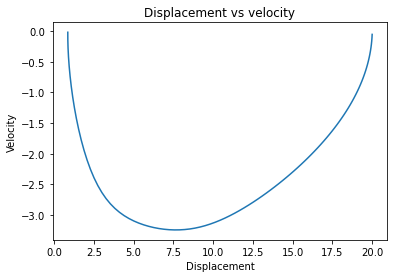

[25] loss: 0.536


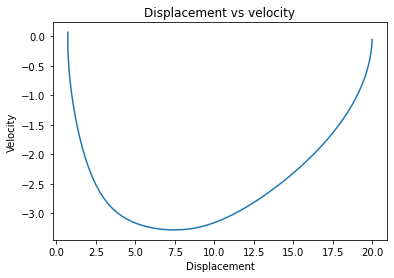

[26] loss: 0.367


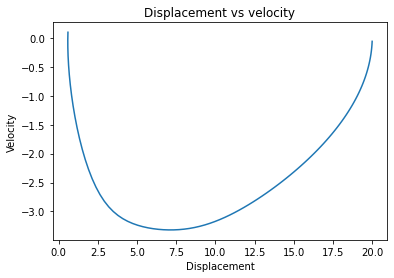

[27] loss: 0.182


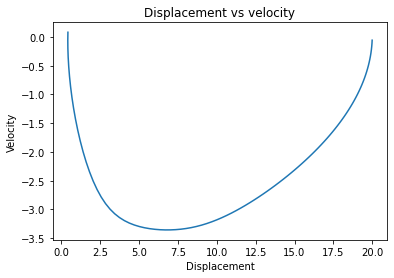

[28] loss: 0.082


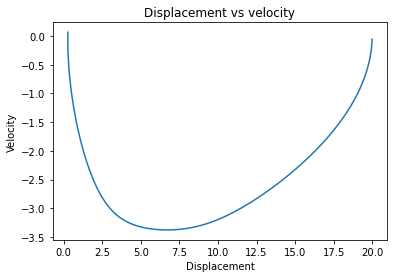

[29] loss: 0.041


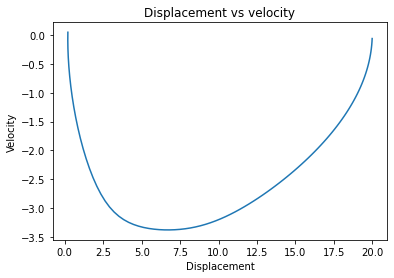

[30] loss: 0.023


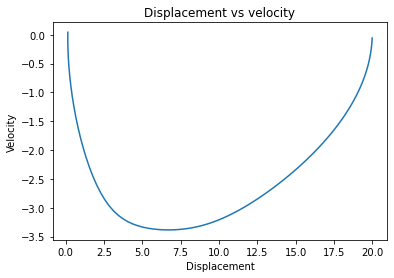

In [11]:
# Now it's time to run the code!

T = 100  # number of time steps
dim_input = 2  # state space dimensions
dim_hidden = 5  # latent dimensions
dim_output = 1  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(30)  # solve the optimization problem



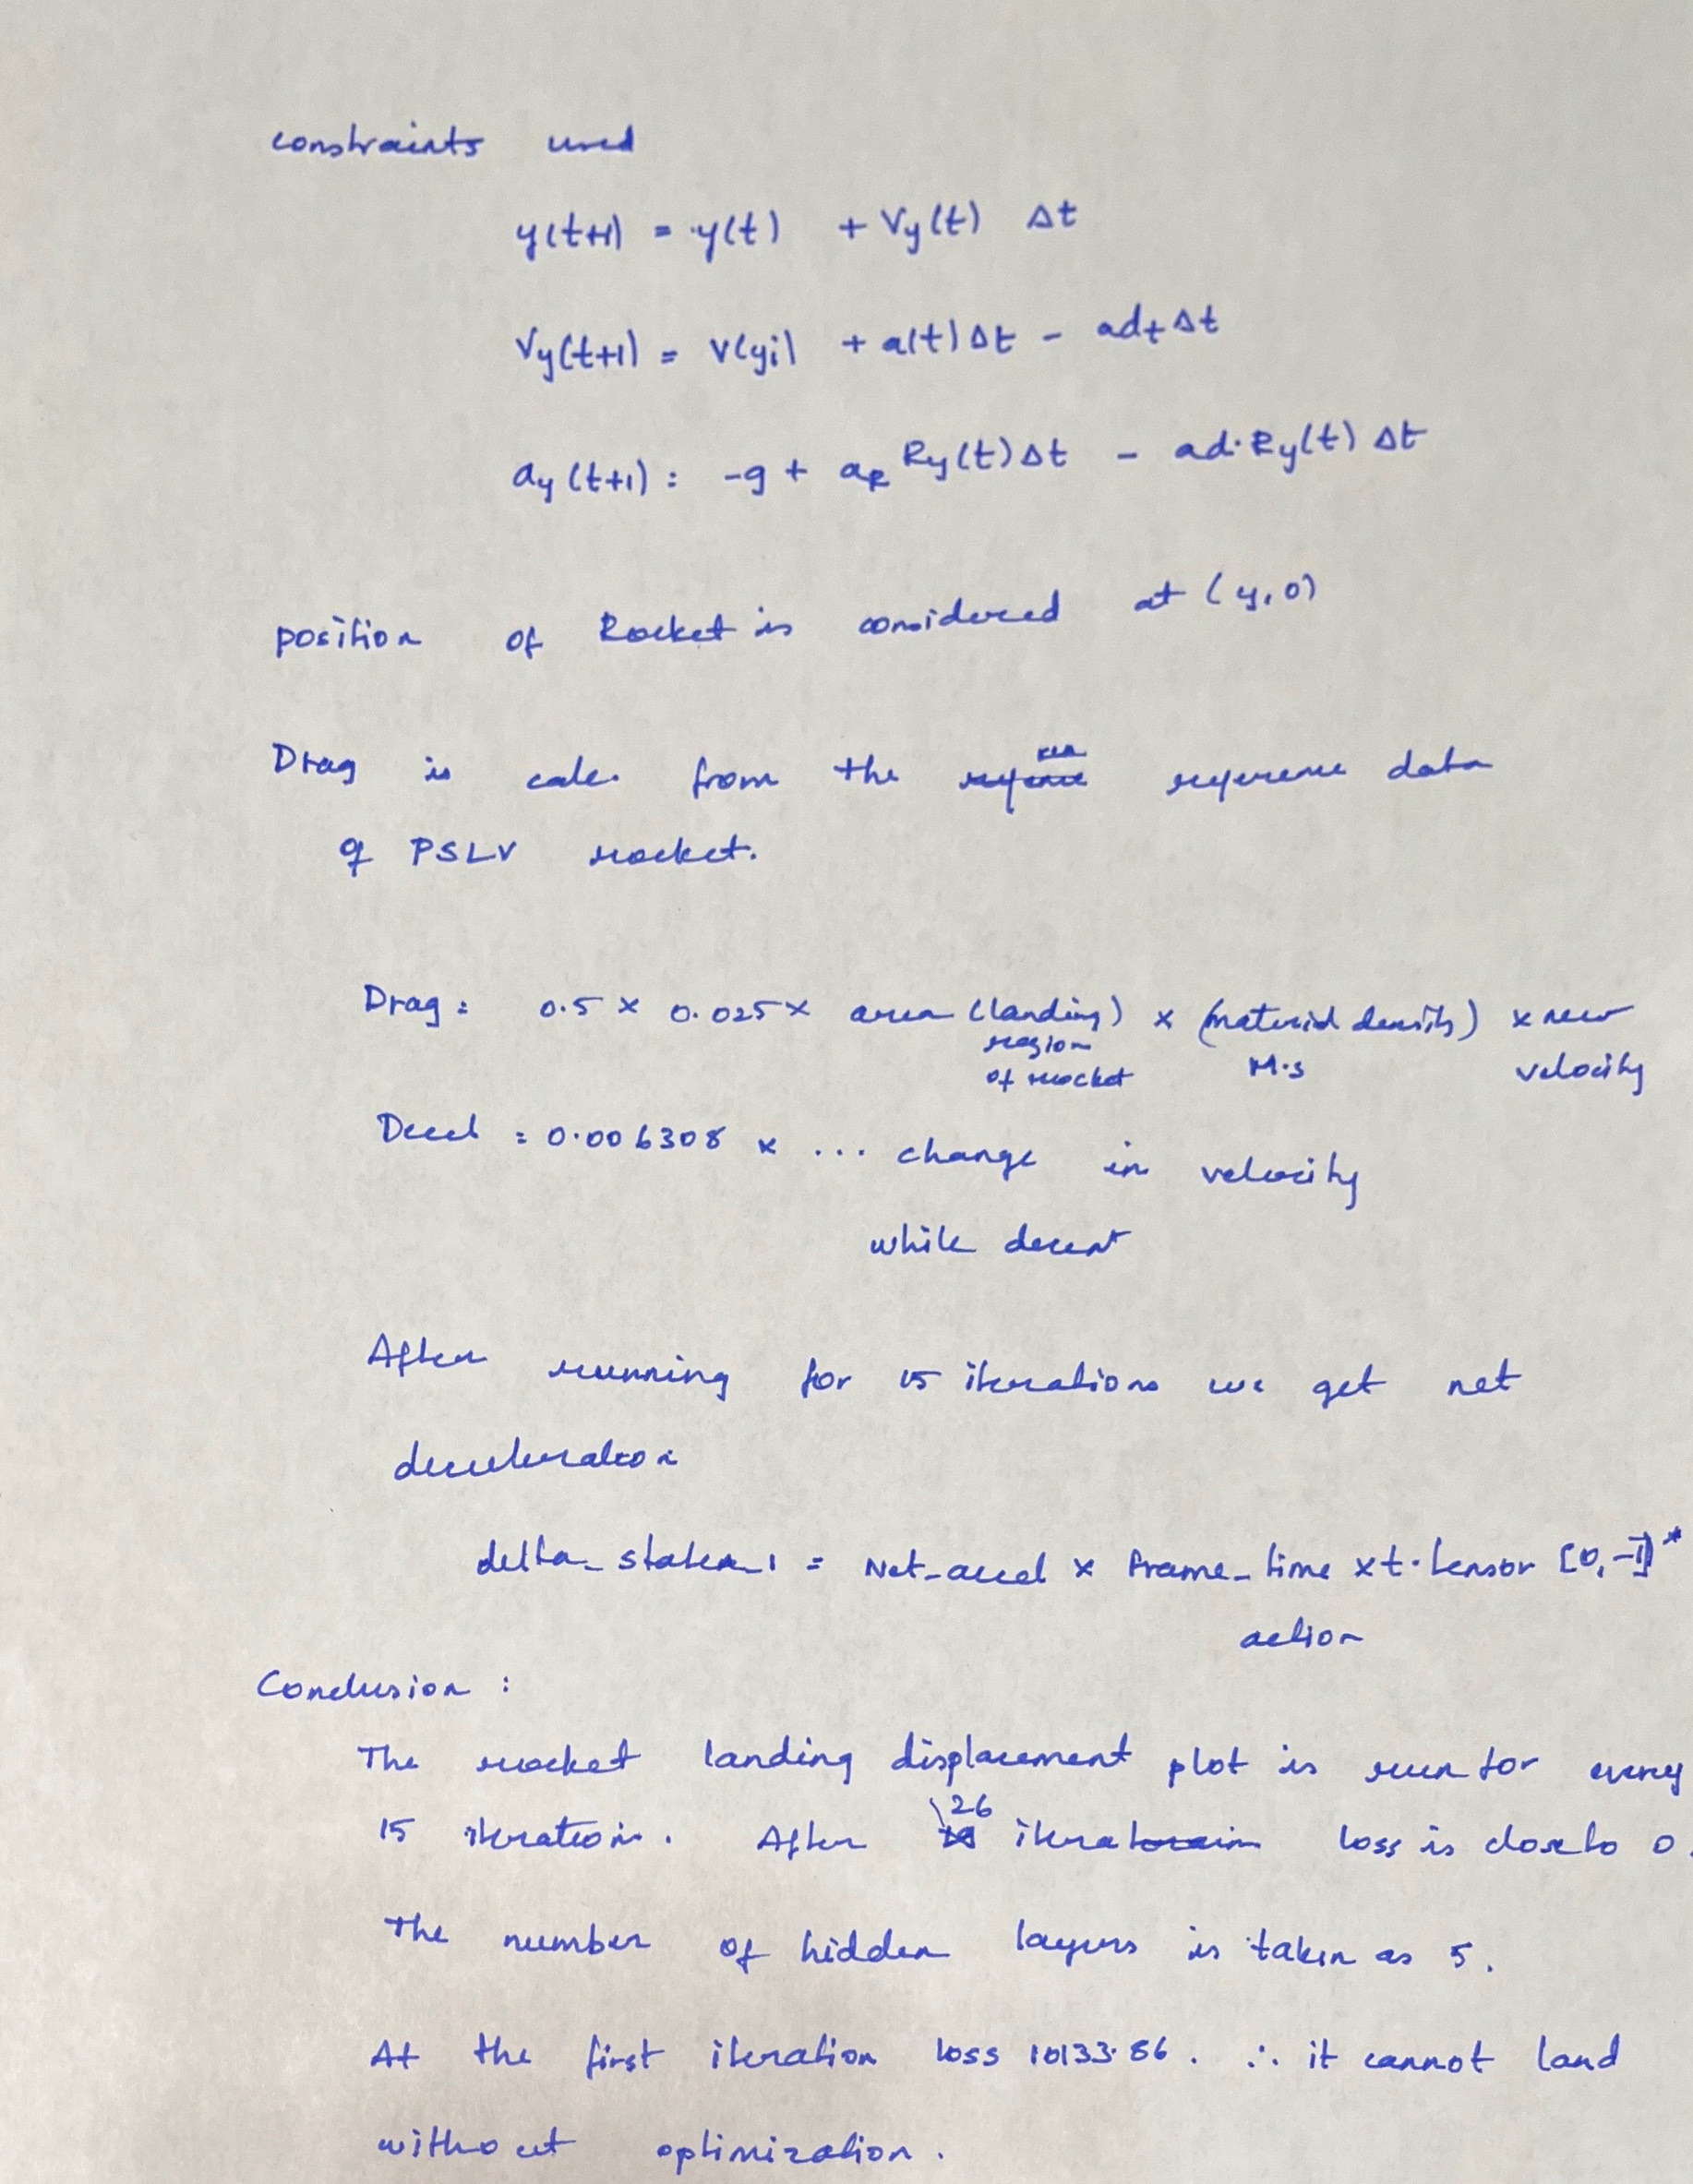